In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from backtester.data_handler import DataHandler
from backtester.backtester import Backtester
from backtester.metrics import Metrics
from backtester.strategy import Strategy
from backtester.chart_plotter import ChartPlotter

In [2]:
SYMBOLS = ['EURUSD']
TIMEFRAMES = [mt5.TIMEFRAME_H1]  # List of timeframes
TIMEFRAME = mt5.TIMEFRAME_H1  # Selecting the specific timeframe for backtest
BARS = 2000
INITIAL_CAPITAL = 10000
LEVERAGE = 10
TRANSACTION_COST = 0.001
RISK_PER_TRADE = 0.01
SPREAD_PERCENT = 0.03  # Spread between entry and TP/SL
TP_SL_RATIO = 2  # Ratio between TP and SL

In [3]:
class MACrossoverStrategy(Strategy):
    def __init__(self, fast_period, slow_period):
        self.fast_period = fast_period
        self.slow_period = slow_period

    def _calculate_moving_averages(self, symbol_data):
        """
        Calculate fast and slow moving averages.
        """
        fast_ma = symbol_data['close'].rolling(window=self.fast_period).mean()
        slow_ma = symbol_data['close'].rolling(window=self.slow_period).mean()
        return fast_ma, slow_ma

    def should_enter_trade(self, symbol_data, index, additional_data=None):
        """
        Entry logic: Enter a long trade when fast MA crosses above slow MA.
                     Enter a short trade when fast MA crosses below slow MA.
        """
        fast_ma, slow_ma = self._calculate_moving_averages(symbol_data)
        
        if fast_ma.iloc[index] > slow_ma.iloc[index] and fast_ma.iloc[index - 1] <= slow_ma.iloc[index - 1]:
            return 'long'
        elif fast_ma.iloc[index] < slow_ma.iloc[index] and fast_ma.iloc[index - 1] >= slow_ma.iloc[index - 1]:
            return 'short'
        return None

    def should_exit_trade(self, open_position, symbol_data, index, additional_data=None):
        """
        Exit logic: Exit long position when fast MA crosses below slow MA.
                    Exit short position when fast MA crosses above slow MA.
        """
        fast_ma, slow_ma = self._calculate_moving_averages(symbol_data)
        
        if open_position['position'] == 'long' and fast_ma.iloc[index] < slow_ma.iloc[index]:
            return True
        elif open_position['position'] == 'short' and fast_ma.iloc[index] > slow_ma.iloc[index]:
            return True
        return False

In [4]:
# 1. Fetch data using DataHandler
data_handler = DataHandler(SYMBOLS, TIMEFRAMES, BARS)
data = data_handler.fetch_data()

In [5]:
ma_crossover_strategy = MACrossoverStrategy(fast_period=50, slow_period=200)

In [6]:

# 3. Initialize and run the backtester
backtester = Backtester(
    initial_capital=INITIAL_CAPITAL, 
    leverage=LEVERAGE, 
    transaction_cost=TRANSACTION_COST, 
    risk_per_trade=RISK_PER_TRADE
)

trades_df = backtester.run_backtest(data, ma_crossover_strategy, timeframe=TIMEFRAME)

In [7]:
# 4. Part A: Display detailed table of all trades
trades_df['capital'] = INITIAL_CAPITAL + trades_df['pnl'].cumsum()
print("Detailed Table of All Trades:")
print(trades_df)

Detailed Table of All Trades:
   symbol  entry_time  exit_time  entry_price  close_price       pnl  \
0  EURUSD         752       1037      1.06750      1.08900 -0.423877   
1  EURUSD         456       1423      1.07534      1.09909 -0.964429   
2  EURUSD         285       1587      1.07974      1.10192 -2.723936   
3  EURUSD        1187       1689      1.08863      1.11117 -0.283630   
4  EURUSD         741       1714      1.07099      1.11422  0.041791   

       capital  data_type  
0  9999.576123  In-sample  
1  9998.611694  In-sample  
2  9995.887758  In-sample  
3  9995.604128  In-sample  
4  9995.645919  In-sample  


In [8]:

# 5. Part B: Display summary table for final results
metrics = Metrics()
performance_summary = metrics.calculate_metrics(trades_df, initial_capital=INITIAL_CAPITAL)

# Convert the performance summary into a DataFrame for display
summary_df = pd.DataFrame(list(performance_summary.items()), columns=['Metric', 'Value'])
print("Summary Table of Final Results:")
print(summary_df)

Summary Table of Final Results:
             Metric         Value
0   Initial Capital  10000.000000
1     Final Capital   9995.645919
2  Maximum Drawdown     -3.971995
3      Sharpe Ratio  -1298.579337
4     Sortino Ratio    -12.636704
5          # Trades      5.000000
6          Win Rate      0.200000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: 'tp'

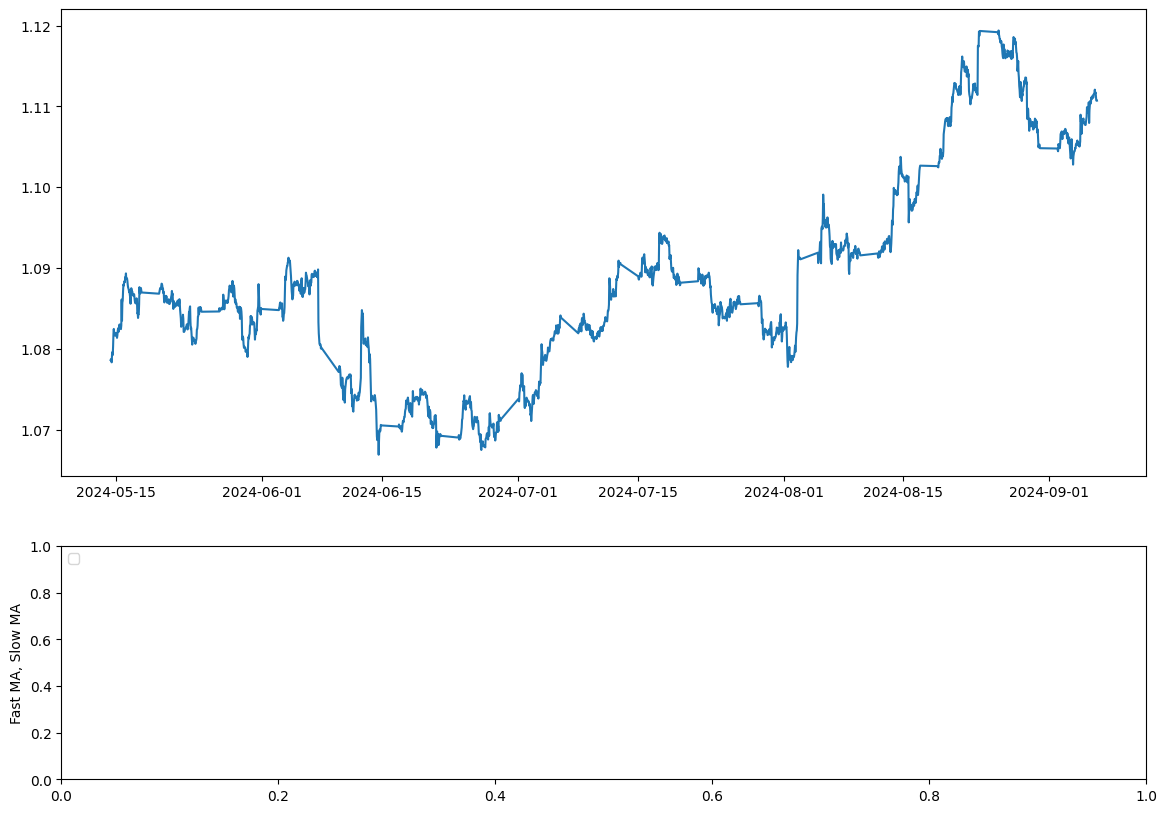

In [9]:
# 6. Part C: Plot trades and indicators for each symbol
chart_plotter = ChartPlotter(
    trades_df=trades_df, 
    shared_data={symbol: data[symbol][TIMEFRAME] for symbol in SYMBOLS},  # Use the 1-hour timeframe data
    indicators={'Fast MA': 'fast_ma', 'Slow MA': 'slow_ma'}  # Plot fast and slow MAs
)

# Plot trades for all symbols
chart_plotter.plot_trades_for_all_symbols()